# Problèmes d'optimisation I

Objectifs :
- Implémentation de la méthode des moindres carrés pour les systèmes linéaires
- Implémentation de la méthode des moindres carrés pour l'approximation polynomiale 
- Implémentation de la méthode du gradient à pas fixe
- Utilisation de la fonction `optimize` de scipy
- Applications à l'extrapolation et à la recherche de minimisateurs de fonctionnelles d'énergie

## Méthode des moindres carrés pour les systèmes linéaires

### L'algorithme

Soit $A\in \mathbb R^{m\times n}$ et $b\in \mathbb R^m$. On dit que
$$
Ax=b \qquad \mbox{au sens des moindres carres}
$$
si la taille de l'erreur $\| Ax-b\|$ est minimale, c'est-à-dire si $\bar x$ est une solution du problème de minimisation :
$$
(1)\qquad \| A\bar x-b\|=\min_{x\in \mathbb R^n} \| Ax-b\|
$$
où $\| \cdot\|$ désigne la norme Euclidienne. Une solution existe toujours, et est unique si $A$ est injective (voir vos notes de cours). De plus, $\bar x$ satisfait $(1)$ si et seulement si $\bar x$ est une solution de
$$
(2) \qquad A^TA\bar x=A^T b.
$$
La fonction `sol_mc(A,b)` ci-dessous calcule ainsi une solution $\bar x$ de $(1)$ en résolvant $(2)$.

In [2]:
import numpy as np
def sol_mc(A,b):
    return(np.linalg.solve(np.transpose(A)@A,np.transpose(A)@b))

On la teste ci-dessous sur l'exemple de la solution de
$$
Ax=b, \qquad A=\begin{pmatrix} 1& 2\\ 3& 4 \\ 5 & 6 \\ 7& 8 \end{pmatrix}, \qquad b=\begin{pmatrix}1 \\ 3 \\ 2 \\ 0 \end{pmatrix}
$$
au sens des moindres carrés.

In [3]:
A1=np.array([[1,2],[3,4],[5,6],[7,8]])
b1=np.array([[1],[3],[2],[0]])
barx1=sol_mc(A1,b1)
barx1,A1@barx1  

(array([[-2.5],
        [ 2.3]]),
 array([[2.1],
        [1.7],
        [1.3],
        [0.9]]))

### La routine numpy

La routine `numpy.linalg.lstsq(A,x)` renvoie une solution de $Ax=b$ au sens des moindres carrés. Si $A$ est injective, alors il existe une unique solution au sens des moindres carrés. Si $A$ n'est pas injective, alors il existe une infinité de solutions au sens des moindres carrés, et `numpy.linalg.lstsq(A,x)` renvoie en première composante (nous ne nous attarderons pas sur les autres composantes) la solution au sens des moindres carrés qui a la plus petite norme euclidienne. On l'illustre ci-dessous sur le calcul de
$$
Ax=b, \qquad A=\begin{pmatrix} 1& 2 & 3 \\ 3& 4 & 7 \\ 5 & 6& 11 \\ 7& 8& 15 \end{pmatrix}, \qquad b=\begin{pmatrix}1 \\ 0\\ 2 \\ 6 \end{pmatrix}
$$
au sens des moindres carrés (dont la solution n'est pas unique).

In [4]:
A2=np.array([[1,2,3],[3,4,7],[5,6,11],[7,8,15]])
b2=np.array([[1],[0],[2],[6]])
barx2=np.linalg.lstsq(A2,b2)[0]
barx2,A2@barx2    #l'avertissement sur le `rcond` parameter n'est pas important

/var/folders/z0/lw5rh1vx3c53rzhdc0_r0lfh0000gn/T/ipykernel_27317/3450001244.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  barx2=np.linalg.lstsq(A2,b2)[0]


(array([[ 1.71666667],
        [-1.43333333],
        [ 0.28333333]]),
 array([[-0.3],
        [ 1.4],
        [ 3.1],
        [ 4.8]]))

### Exercice
__Exercice 1__

On considère l'ensemble de points $E=\{p_0,...,p_{9}\}$ donné par :
\begin{align*}
& p_0=(1.4,0.8), \qquad p_1=(1.2,1) \\
& p_2=(0.9,1.3), \qquad p_3=(0.6,1.2) \\
& p_4=(0.4,1.2), \qquad p_5=(0.3,0.7) \\
& p_6=(0.4,0.6), \qquad p_7=(0.6,0.3) \\
& p_8=(1,0.3), \qquad p_9=(1.3,0.6).
\end{align*}
On le représente graphiquement ci-dessous.

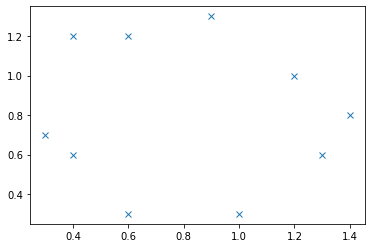

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
p1=np.array([1.4,1.2,0.9,0.6,0.4,0.3,0.4,0.6,1,1.3])
p2=np.array([0.8,1,1.3,1.2,1.2,0.7,0.6,0.3,0.3,0.6])
plt.plot(p1,p2,"x")

On souhaite approximer $E$ par un cercle $C$ de centre $c=(a,b)$ et de rayon $R$. En notant $\pi(p_i)$ la projection du point $p_i$ sur le cercle, l'erreur entre $\pi(p_i)$ et $p_i$ est définie comme $e_i=|\|p_i-c \|^2-R^2|$. On admet (vous pouvez le démontrer en exercice) que
$$
(3) \qquad e_i=|(x_i-a)^2+(y_i-b)^2-R^2|
$$
où on a écrit $p_i=(x_i,y_i)$. On définit alors l'erreur totale de l'approximation de l'ensemble $E$ par le cercle $C$ comme
$$
e(a,b,R)= \sum_{0}^9 e_i^2= \sum_0^9 ((x_i-a)^2+(y_i-b)^2-R^2)^2
$$
Le meilleur cercle $\bar C$ sera alors celui dont le centre $\bar c=(\bar a,\bar b)$ et le rayon $\bar R$ sont ceux qui minimisent l'erreur totale :
$$
(5) \qquad e(\bar a, \bar b,\bar R)=\min_{a,b,R}e(a,b,R)
$$

__1.__ On pose $u=(a,b,R^2-a^2-b^2)$, de sorte que $u_0=a$, $u_1=b$ et $u_2=R^2-a^2-b^2$. Montrer à la main que
$$
(6)\qquad e(a,b,R)= \sum_0^9 (2x_iu_0+2y_iu_1+u_2-x_i^2-y_i^2)^2 = \| Au-v\|^2
$$
où
$$
A=\begin{pmatrix} 2x_0 & 2y_0 & 1\\ 2x_1 & 2y_1 & 1\\ . & . & . \\ 2x_{n-1} & 2y_{n-1} & 1\\\end{pmatrix} \qquad \mbox{and} \qquad v=\begin{pmatrix} x_0^2+y_0^2\\ x_1^2+y_1^2\\. \\ x_{n-1}^2+y_{n-1}^2 \end{pmatrix}
$$

__2.__ Calculer numériquement (en utilisant `sol_mc` définie plus haut ou `np.linalg.lstsq`) que la solution de $Au=v$ au sens des moindres carrés est
$$
u=(0.82,0.79,-1.02).
$$

__3.__
En déduire (à la main) que le meilleur cercle $\bar C$ qui résout le problème de minimisation $(5)$ est celui de centre $(0.82,0.79)$ et de rayon $0.53$.

__4.__ Représenter numériquement dans un même graphique l'ensemble de points $E$ et le cercle $\bar C$.

## Méthode des moindres carrés pour l'approximation polynomiale

### L'algorithme

On souhaite approximer une fonction $f:\mathbb R \rightarrow \mathbb R$ par un polynôme
$$
P(x)=\sum_{j=0}^d a_j x^j.
$$
On note $a=(a_0,...,a_d)^T$ vecteur des coefficients du polynôme $P$. Étant donnés des points $x_0<...<x_{n-1}$, on pose $y=(f(x_0),...,x(x_{n-1}))^T$. On définit alors le polynôme de degré $d$ qui approxime $f$ en les points $x_0,...,x_{n-1}$ au sens des moindres carrés comme la solution $\bar P$ du problème de minimisation
$$
(7) \qquad \sum_0^{n-1} |y_i-\bar P(x_i)|^2=\min_{P \text{ de degre }d} \sum_0^n |y_i- P(x_i)|^2.
$$
Pour le vecteur des coefficients $\bar a$ cela est équivalent à:
$$
\|y-M\bar a\|^2=\min_{a\in \mathbb R^{d+1}}\|y-Ma\|^2, \qquad \mbox{avec}\qquad M=\begin{pmatrix} 1 & x_0 & x_0^2&...&x_0^d \\ 
1 & x_1 & x_1^2&...&x_1^d \\ 
& & & &\\
& & & &\\
1 & x_n & x_n^2&...&x_n^d \\ \end{pmatrix} \in \mathbb R^{(n+1)\times (d+1)}.
$$
Pour $d\leq n$ la solution du problème de minimisation ci-dessus est donnée par l'unique solution du problème linéaire:
$$
(8) \qquad M^TM\bar a=M^T y.
$$
La fonction `poly_mc(x,y,d)` ci-dessous calcule la solution $\bar a$ de $(8)$ puis renvoie le polynôme correspondant. Pour éviter les erreurs dues à un code trop long, on définit d'abord la fonction auxiliaire `poly_mc_M(x,d)` qui calcule la matrice $M$:

In [134]:
def poly_mc_M(x,d):
    n=len(x)-1
    M=np.zeros([n+1,d+1])
    for i in range(n+1):     #creation de la matrice M associee au vecteur x
        for j in range(d+1):
            M[i,j]=x[i]**j
    return(M)

On teste `poly_mc_M(x,d)` sur l'exemple $x=(0,1,2,3,4)$ et $d=3$

In [135]:
x1=np.arange(1,5,1)
poly_mc_M(x1,3)
poly_mc_M(x2,3)

array([[  1.,   0.,   0.,   0.],
       [  1.,   2.,   4.,   8.],
       [  1.,   4.,  16.,  64.],
       [  1.,   6.,  36., 216.],
       [  1.,   8.,  64., 512.]])

On définit alors `poly_mc(x,y,d)` comme suit:

In [57]:
import numpy as np
def poly_mc(x,y,d):
    M=poly_mc_M(x,d)
    abar=np.linalg.solve(np.transpose(M)@M,np.transpose(M)@np.transpose(y))
    def poly_mc_aux(x):
        z=np.array([abar[i]*(x**i) for i in range(d+1)])
        return(np.sum(z))
    return(poly_mc_aux)

On illustre `poly_mc(x,y,d)` en prenant $f(x)=\cos(x)$, et en calculant le polynôme des moindres carrés pour les points $0,2,4,6,8$ et un degré 3.

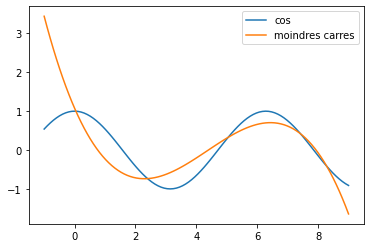

In [58]:
import matplotlib.pyplot as plt
x2=np.arange(0,9,2)
y2=np.cos(x2)
x2bis=np.linspace(-1,9,100)
y2bis=np.cos(x2bis)
p2=poly_mc(x2,y2,3)
y2mc=np.array([p2(x2bis[i]) for i in range(100)])
plt.plot(x2bis,y2bis,label="cos")
plt.plot(x2bis,y2mc,label="moindres carres")
plt.legend()

### La routine de numpy

La fonction `numpy.polynomial.polynomial.polyfit(x,y,d)` renvoie, pour $x=(x_0,...,x_n)$ et $y=(y_0,...,y_n)=(f(x_1),...,f(x_n))$ les coefficients $(a_0,...,a_d)$ du polynome $\sum_{i=0}^d a_i x^i$ de degré $d$ solution de $(7)$, c'est-à-dire qui approxime la fonction $f$ en les points $x_0,...,x_n$ au sens des moindres carrés.

On illustre ci-dessous son utilisation pour calculer le polynôme de degré $2$, pour les points $x=(0,1,2,3)$ et les valeurs $y=(0,0,1,1)$.

In [52]:
import numpy.polynomial as np_poly
x3=np.array([0,1,2,3])
y3=np.array([0,0,1,1])
p3=np_poly.polynomial.polyfit(x3,y3,2)

### Exercice

__Exercice 2__

Le produit intérieur brut (en milliers de milliards de dollars, ajusté à l'inflation) de l'Allemage était par année en 1990 de $1.6$, en 1995 de $2.59$, en 2000 de $1.95$, en 2005 de $2.85$, en 2010 de $3.4$, en 2015 de $3.36$ et en 2020 de $3.88$.


__1.__
Calculer numériquement le polynôme d'interpolation de Lagrange du PIB de l'Allemagne associé aux points (1990,1995,2000,2005,2010,2015,2020). Représentez graphiquement ce polynôme entre 1990 et 2030. Que voyez-vous ? Pensez-vous que ce soit une bonne projection de l'évolution du PIB de l'Allemagne ?

(La réponse est non : approximer une fonction par son polynôme d'interpolation de Lagrange est en général une mauvaise idée. La raison pour cela est le phénomène de Runge, qui est décrit dans la feuille de TP "approximation de fonctions")

__2.__ Déterminer numériquement le polynôme $P$ de degré 3 qui approxime au sens des moindres carrés le PIB de l'Allemagne pour les points $(1990,1995,2000,2005,2010,2015,2020)$. Vous pouvez vous aider de la fonction `poly_mc(x,y,d)` codée plus haut ou de `numpy.polynomial.polynomial.polyfit(x,y,d)`.

Représentez graphiquement ce polynôme entre 1990 et 2030. Constatez que c'est une projection raisonnable de l'évolution du PIB de l'Allemagne.

__3.__ Le produit intérieur brut de l'Inde était par année en 1990 de $0.33$, en 1995 de $0.37$, en 2000 de $0.48$, en 2005 de $0.84$, en 2010 de $1.7$, en 2015 de $2.1$ et en 2020 de $2.7$.Déterminer numériquement le polynôme $Q$ de degré 3 qui approxime au sens des moindres carrés le PIB de l'Inde pour les points $(1990,1995,2000,2005,2010,2015,2020)$.

__4.__
On souhaite faire une estimation de l'année lors de laquelle le PIB de l'Inde dépassera celui de l'Allemagne.

Déterminer l'année $a\geq 2020$ pour laquelle $P(a)=Q(a)$. Vous pouvez utiliser la méthode de votre choix figurant sur la feuille de cours "résolution de systèmes non linéaires".

## Méthode du gradient à pas fixe pour l'optimisation sans contrainte

### L'algorithme

On cherche à minimiser une fonction $f\in \mathcal C^1(\mathbb R^n,\mathbb R)$, c'est-à-dire à déterminer un point $\bar x$ (s'il existe) tel que
$$
f(\bar x)=\min_{x\in \mathbb R^n} f(x).
$$
On fixe un pas $\rho>0$. On choisit un point initial $x_0\in \mathbb R^n$. On calcule alors $x_1$ par $x_1=x_0-\rho Jf(x_0)$, où $JF$ désigne la matrice jacobienne de $F$. On itère ensuite cette procédure : $x_k$ étant connu, le point suivant est
$$
x_{k+1}=x_k-\rho JF(x_k).
$$
Sous certaines hypothèses, cf notes de cours, la suite $(x_k)_{k\in \mathbb N}$ converge vers un minimum local $\bar x$ de $f$. On fixe un seuil d'erreur $\epsilon_0>0$, et on arrête l'algorithme si $\| x_{k}-x_{k-1}\|\leq \epsilon_0$.

Il se peut également que la suite $(x_k)_{k\in \mathbb N}$ ne converge pas. On fixe donc au préalable une limite maximale d'itération $N\in \mathbb N$, et on arrête l'algorithme si $k\geq N$.

La fonction `grad_pasfixe(Df,rho,x0,e0,N)` ci-dessous renvoie le résultat de la méthode de descente du gradient à pas fixe.

In [53]:
def grad_pasfixe(Df,rho,x0,e0,N):
    x=x0
    y=x0
    e=2*e0
    n=0
    while n<N and e>e0:
        y=x-rho*Df(x)
        e=np.linalg.norm(y-x)
        x=y
        n=n+1
    if n<N:
        return(x)
    else:
        return("l'algorithme n'a pas converge")

On teste `grad_pasfixe(Df,rho,x0,e0,N)` ci-dessous pour calculer un minimiseur de la fonction
$$
f(x,y)=x^4+y^6-xy.
$$
On représente d'abord graphiquement la fonction à l'aide de `pyplot.colormesh`.

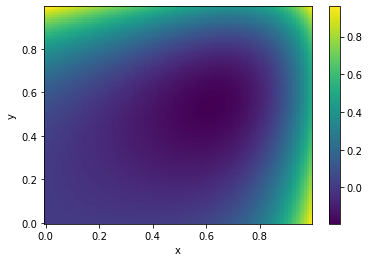

In [87]:
x3 = np.arange(0,1,0.01)
y3 = np.arange(0,1,0.01)
(X3,Y3) = np.meshgrid(x3, y3) # grille de points
n3=len(x3)
def func3(x,y):
    return(x**4+y**6-x*y)
Z3=np.zeros([n3,n3])
for i in range(n3):
    for j in range(n3):
        Z3[i,j]= func3(x3[i],y3[j])
plt.pcolormesh(X3, Y3, Z3) 
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()

On constate qu'un minimum a l'air d'exister près du point $(0.6,0.6)$. On détermine ce minimum numériquement à l'aide de la méthode du gradient à pas fixe. On choisit un point initial non loin, par exemple $(1,1)$.

In [66]:
def Df4(x):
    return(np.array([4*((x[0])**3)-x[1],6*((x[1])**5)-x[0]]))
x0=np.array([1,1])
grad_pasfixe(Df4,0.1,x0,0.01,10)

array([0.54321902, 0.61345549])

### Exercice

__Exercice 3__

__1.__ Reprendre le code de la fonction `grad_pasfixe` et écrire une fonction `points_grad_pasfixe(Df,rho,x0,e0,N)` qui renvoie les 10 premiers points $(x_0,...,x_{10})$ de l'algorithme du gradient à pas fixe.

__2.__
Reprendre l'exemple de la fonction $f(x,y)=x^4+y^6-xy$, et dessiner les 10 premiers points $(x_0,...,x_{10})$ de l'algorithme du gradient à pas fixe, pour un point initial $x_0$ de votre choix.

## Routines de scipy pour l'optimisation sans contrainte

La routine `minimize` de scipy.optimize permet de minimiser une fonctionnelle. Elle peut implémenter différentes méthodes, qui nécessiteront de lui donner différents argument. Au minimum, il faut lui donner en argument la fonction à minimiser et un point d'initialisation $x_0$. Ci-dessous on traite l'exemple du problème de minimisation :
$$
1-\overline{x}_0^2+\overline{x}_1+\overline{x}_0^4+\overline{x}_1^6= \min_{x\in \mathbb R^2} \ 1-x_0^2+x_1+x_0^4+x_1^6
$$
On commence par représenter graphiquement la fonction pour déterminer grossièrement la position d'un minimiseur.

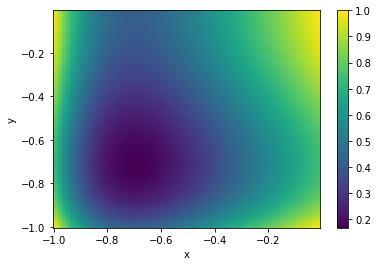

In [104]:
x4 = np.arange(-1,0,0.01)
y4 = np.arange(-1,0,0.01)
(X4,Y4) = np.meshgrid(x4, y4) # grille de points
n4=len(x4)
def func4(x,y):
    return(1-x**2+y+x**4+y**6)
Z4=np.zeros([n4,n4])
for i in range(n4):
    for j in range(n4):
        Z4[i,j]= func4(x4[i],y4[j])
plt.pcolormesh(X4, Y4, Z4) 
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()

On constate qu'il devrait y avoir un minimum près de $(-0.6,-0.6)$. On le détermine numériquement en prenant un point initial proche de ce point pour `scipy.optimize`

In [107]:
import scipy.optimize as opt
def func4(x):
    return(1-x[0]**2+x[1]+x[0]**4+x[1]**6)
opt.minimize(func4,np.array([-0.6,0.6]))

      fun: 0.16764406769156392
 hess_inv: array([[ 0.22828021, -0.01012025],
       [-0.01012025,  0.13503788]])
      jac: array([-2.60397792e-06, -2.17370689e-06])
  message: 'Optimization terminated successfully.'
     nfev: 33
      nit: 8
     njev: 11
   status: 0
  success: True
        x: array([-0.70710744, -0.69882743])

Pour plus de détails, appelez l'aide help(scipy.optimize.minimize).

### Exercice
__Exercice 4__

Utiliser `scipy.optimize` pour trouver le minimum de la fonction
$$
(2-x)^2+100(2y-x^2)^2 .
$$